In [5]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch 

model_name = "seara/rubert-base-cased-russian-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

classifier = pipeline(
    "text-classification",
    model=model_name,
    tokenizer=tokenizer,
    framework="pt"
)

result = classifier("Сервис ужасный, больше не вернусь!")
print(result)

Device set to use mps:0


[{'label': 'negative', 'score': 0.7565039992332458}]


In [9]:
with open('/Users/vldlbnv/Магистратура/1 курс/модуль 4/Прикладная лингвистика 2/Замятин_Мы') as file1, open('/Users/vldlbnv/Магистратура/1 курс/модуль 4/Прикладная лингвистика 2/Оруэлл_1984') as file2:
    text_zamyatin = file1.read()
    text_orwell = file2.read()

# Токенизация с обрезкой и дополнением
inputs = tokenizer(
    text_zamyatin,
    max_length=512,          # Максимальная длина
    padding="max_length",    # Дополнить до 512 токенов
    truncation=True,         # Обрезать текст, если он длиннее 512
    return_tensors="pt"      # Вернуть тензоры PyTorch
)

# Передача в модель
with torch.no_grad():
    outputs = model(**inputs)

# Обработка результатов
logits = outputs.logits
probabilities = torch.softmax(logits, dim=1).squeeze().tolist()
labels = ["NEGATIVE", "POSITIVE", "NEUTRAL"]
result = {label: round(prob * 100, 2) for label, prob in zip(labels, probabilities)}
print(result)

inputs = tokenizer(
    text_orwell,
    max_length=512,          # Максимальная длина
    padding="max_length",    # Дополнить до 512 токенов
    truncation=True,         # Обрезать текст, если он длиннее 512
    return_tensors="pt"      # Вернуть тензоры PyTorch
)

# Передача в модель
with torch.no_grad():
    outputs = model(**inputs)

# Обработка результатов
logits = outputs.logits
probabilities = torch.softmax(logits, dim=1).squeeze().tolist()
labels = ["NEGATIVE", "POSITIVE", "NEUTRAL"]
result = {label: round(prob * 100, 2) for label, prob in zip(labels, probabilities)}
print(result)

{'NEGATIVE': 70.65, 'POSITIVE': 25.84, 'NEUTRAL': 3.51}
{'NEGATIVE': 74.96, 'POSITIVE': 14.12, 'NEUTRAL': 10.91}


In [31]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from keybert import KeyBERT
from nltk.corpus import stopwords
import nltk
import re
import spacy

# Загрузка необходимых данных для NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

# Загрузка модели spacy для русского языка
nlp = spacy.load("ru_core_news_sm")

# Функция для предобработки текста
def preprocess_text(text):
    # Удаление специальных символов, чисел и лишних пробелов
    text = re.sub(r"[^а-яА-ЯёЁ\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.lower().strip()

    # Лемматизация и удаление стоп-слов
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words]
    return " ".join(tokens)

# Загрузка модели и токенизатора
model_name = "seara/rubert-base-cased-russian-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Функция для классификации текста
def classify_text(text):
    inputs = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()
    labels = ["NEGATIVE", "POSITIVE", "NEUTRAL"]
    return {label: round(prob * 100, 2) for label, prob in zip(labels, probabilities)}

# Функция для извлечения ключевых слов через attention weights
def extract_keywords_with_attention(text, model, tokenizer):
    inputs = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)

    attentions = outputs.attentions[-1].mean(dim=1).squeeze().tolist()  # Среднее внимание последнего слоя
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

    # Создаем пары (токен, внимание)
    token_attention_pairs = list(zip(tokens, attentions))
    # Фильтруем специальные токены и выбираем топ-N токенов
    filtered_pairs = [(token, attention) for token, attention in token_attention_pairs if token not in ['[CLS]', '[SEP]', '[PAD]']]
    filtered_pairs.sort(key=lambda x: x[1], reverse=True)  # Сортируем по вниманию

    return filtered_pairs[:10]  # Возвращаем топ-10 ключевых слов

# Функция для извлечения ключевых слов через KeyBERT
def extract_keywords_with_keybert(text):
    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), top_n=10)
    return keywords

# Чтение текстов
with open('/Users/vldlbnv/Магистратура/1 курс/модуль 4/Прикладная лингвистика 2/антиутопии/Мы.txt') as file1, \
     open('/Users/vldlbnv/Магистратура/1 курс/модуль 4/Прикладная лингвистика 2/антиутопии/1984.txt') as file2:
    text_zamyatin = file1.read()
    text_orwell = file2.read()

# Предобработка текстов
text_zamyatin = preprocess_text(text_zamyatin)
text_orwell = preprocess_text(text_orwell)

# Анализ текста "Мы" Евгения Замятина
print("\nАнализ текста 'Мы' Евгения Замятина:")
result = classify_text(text_zamyatin)
print("Сентимент:", result)

# Извлечение ключевых слов через attention
keywords_attention = extract_keywords_with_attention(text_zamyatin, model, tokenizer)
print("Ключевые слова (attention):", keywords_attention)

# Извлечение ключевых слов через KeyBERT
keywords_keybert = extract_keywords_with_keybert(text_zamyatin)
print("Ключевые слова (KeyBERT):", keywords_keybert)

# Анализ текста "1984" Джорджа Оруэлла
print("\nАнализ текста '1984' Джорджа Оруэлла:")
result = classify_text(text_orwell)
print("Сентимент:", result)

# Извлечение ключевых слов через attention
keywords_attention = extract_keywords_with_attention(text_orwell, model, tokenizer)
print("Ключевые слова (attention):", keywords_attention)

# Извлечение ключевых слов через KeyBERT
keywords_keybert = extract_keywords_with_keybert(text_orwell)
print("Ключевые слова (KeyBERT):", keywords_keybert)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vldlbnv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Анализ текста 'Мы' Евгения Замятина:
Сентимент: {'NEGATIVE': 77.8, 'POSITIVE': 4.11, 'NEUTRAL': 18.1}
Ключевые слова (attention): [('литературный', [0.009429270401597023, 0.0014803237281739712, 0.0006809427868574858, 0.000507669523358345, 0.0005520140985026956, 0.0003948694793507457, 0.0004410230612847954, 0.0003492743708193302, 0.000575571961235255, 0.0006008984055370092, 0.0007663136930204928, 0.000316941732307896, 0.0005369915743358433, 0.0002535187522880733, 0.0008105835877358913, 0.0008358580525964499, 0.003118791850283742, 0.00029172044014558196, 0.0004960175137966871, 0.0020892492029815912, 0.00161867740098387, 0.003292481182143092, 0.0024214880540966988, 0.0010893672006204724, 0.0010662866989150643, 0.0005334875895641744, 0.00018526504572946578, 0.00022772095690015703, 0.00020813976880162954, 0.0011020639212802052, 0.0001670888887019828, 0.0004144025733694434, 0.004770264495164156, 0.0035784572828561068, 0.003170204581692815, 0.001465710811316967, 0.0010715967509895563, 0.0080

Ключевые слова (KeyBERT): [('философскопсихологический', 0.4733), ('импрессионистский', 0.457), ('философскопсихологическое', 0.4562), ('автокомментария', 0.4377), ('интроспекция', 0.425), ('европейский', 0.4187), ('апокалиптический', 0.4142), ('восприятие', 0.4137), ('апросиной', 0.4133), ('фотографический', 0.4101)]


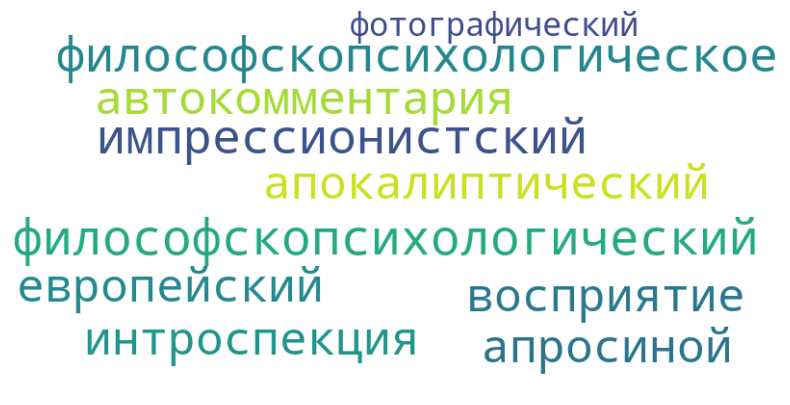

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_word_cloud(keywords):
    # Генерация облака слов
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        colormap='viridis', 
        prefer_horizontal=1.0
    ).generate_from_frequencies(keywords)

    # Отображение облака слов
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Отключение осей
    plt.show()
    
    # Извлечение ключевых слов через KeyBERT
keywords_keybert = extract_keywords_with_keybert(text_zamyatin)
print("Ключевые слова (KeyBERT):", keywords_keybert)

# Преобразование ключевых слов в словарь
keywords_dict = {word: score for word, score in keywords_keybert}

# Создание облака слов
create_word_cloud(keywords_dict)

Ключевые слова (KeyBERT): [('способный', 0.396), ('беспорядочный', 0.3951), ('благоприятный', 0.3951), ('определённый', 0.3897), ('восприятие', 0.3891), ('спроси', 0.3872), ('жукоподобный', 0.3871), ('спокойный', 0.3859), ('фронтиспис', 0.3831), ('исполнительный', 0.3831)]


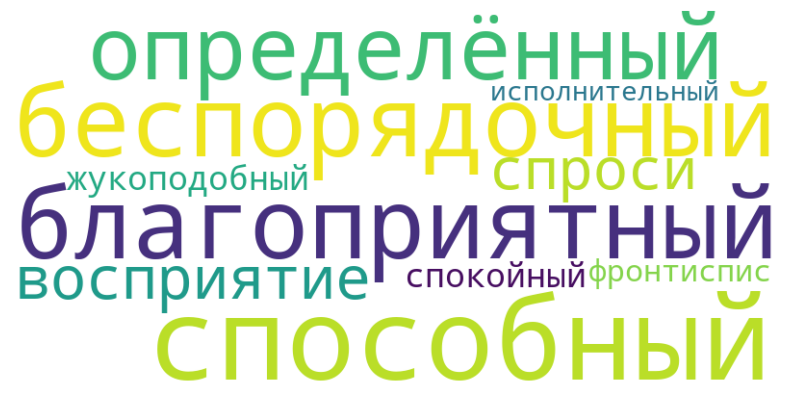

In [33]:
keywords_keybert = extract_keywords_with_keybert(text_orwell)
print("Ключевые слова (KeyBERT):", keywords_keybert)

# Преобразование ключевых слов в словарь
keywords_dict = {word: score for word, score in keywords_keybert}

# Создание облака слов
create_word_cloud(keywords_dict)
